In [111]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp

In [ ]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 2), (0, 4), (0, 5), (0, 8), (0, 9),
        (1, 3), (1, 6), (1, 7), (1, 10), (1, 11),
        (2, 6), (2, 7), (2, 8), (2, 9), (3, 4),
        (3, 5), (3, 10), (3, 11), (4, 5), (4, 8),
        (4, 10), (5, 9), (5, 11), (6, 7), (6, 8),
        (6, 10), (7, 9), (7, 11), (8, 10), (9, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_ising_icosahedral_dense(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model in dense format.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix in dense format.
    """
    # Pauli matrices
    X = pauli_x()
    Z = pauli_z()
    I = np.eye(2)
    
    # Initialize the Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

     # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat

def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem_size, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, list(range(subsystem_size)), [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, list(range(subsystem_size)), [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy


def entanglement_entropy_qutip(psi, subsystem_size, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, list(range(subsystem_size)))
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

def generate_spin_basis_with_binary(n_spins):
    """
    Generates the canonical basis for n spins, where each spin state (0 or 1)
    is represented as a vector, and the full basis is constructed using the tensor product.
    Also includes the binary string representation of each basis state.

    Parameters:
        n_spins (int): Number of spins.

    Returns:
        list of tuples: Each tuple contains the binary string and the corresponding basis vector.
    """
    # Define the spin-0 and spin-1 vectors
    spin_0 = np.array([1, 0])  # |0> = [1, 0]
    spin_1 = np.array([0, 1])  # |1> = [0, 1]

    # Generate all possible binary configurations for n spins
    basis = []
    for i in range(2**n_spins):
        # Convert the integer i to a binary representation of length n_spins
        binary_state = [(i >> j) & 1 for j in range(n_spins)]
        binary_string = ''.join(map(str, reversed(binary_state)))  # Binary string representation
        
        # Start with the first spin state
        state_vector = spin_0 if binary_state[0] == 0 else spin_1
        
        # Take the tensor product for the remaining spins
        for bit in binary_state[1:]:
            state_vector = np.kron(state_vector, spin_0 if bit == 0 else spin_1)
        
        basis.append((binary_string, state_vector))
    
    return basis

In [113]:
# start setting up C5 on the icosahedron

N = 12  # Number of spins
dim = 2**N  # Hilbert space dimension
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

# Define the C5 permutation mapping for your case - around axis through vert 9 and 10
perm = {
    0: 2,
    2: 7,
    7: 11,
    11: 5,
    5: 0,
    1: 3,
    3: 4,
    4: 8,
    8: 6,
    6: 1,
    9: 9,   # Fixed
    10: 10  # Fixed
}

In [114]:
# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

In [115]:
# Example usage of the permutation function on a given state

state = [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]
print("state", state)
state1 = apply_permutation(state)
print("state1", state1)
state2 = apply_permutation(state1)
print("state2", state2)
state3 = apply_permutation(state2)
print("state3", state3)
state4 = apply_permutation(state3)
print("state4", state4)
state5 = apply_permutation(state4)
print("state5", state5)

state [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]
state1 [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
state2 [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]
state3 [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]
state4 [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
state5 [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]


In [116]:
P = dok_matrix((dim, dim), dtype=np.float64)

# Go through all basis states
for index in range(dim):
    # Convert index to spin bits
    state_bits = list(map(int, np.binary_repr(index, width=N)))
    
    # Apply the permutation
    new_bits = apply_permutation(state_bits)
    
    # Convert back to integer index
    new_index = int("".join(map(str, new_bits)), 2)
    
    # Set the permutation matrix entry
    P[new_index, index] = 1.0

# Optionally convert to CSR format for efficient multiplication
P = P.tocsr()

print("Permutation matrix P constructed with shape:", P.shape)

Permutation matrix P constructed with shape: (4096, 4096)


In [117]:
# check that P is unitary and  that it is a permutation matrix - P^5 = 1

# Verify if P is Hermitian
P_dagger = P.conjugate().transpose()  # Hermitian transpose of P
is_hermitian = np.allclose(P.toarray(), P_dagger.toarray(), atol=1e-10)

print(f"Is P Hermitian? {is_hermitian}")
# Verify that P is unitary
P_dagger = P.conjugate().transpose()  # Hermitian transpose of P
identity_check = P @ P_dagger  # Should equal the identity matrix
is_unitary = np.allclose(identity_check.toarray(), np.eye(dim), atol=1e-10)

print(f"Is P unitary? {is_unitary}")

# Verify that P^5 = I
P_power_5 = P
for _ in range(4):  # Multiply P by itself 4 more times
    P_power_5 = P_power_5 @ P

identity_check_power_5 = P_power_5  # Should equal the identity matrix
is_permutation_matrix = np.allclose(identity_check_power_5.toarray(), np.eye(dim), atol=1e-10)

print(f"Does P^5 equal the identity matrix? {is_permutation_matrix}")

Is P Hermitian? False
Is P unitary? True
Does P^5 equal the identity matrix? True


In [118]:

# Diagonalize the sparse matrix P
# Compute all eigenvalues and eigenvectors of P
eigenvalues, eigenvectors = np.linalg.eig(P.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")
# Print the eigenvalues
print("Eigenvalues of P:")
print(eigenvalues)

# Find the unique eigenvalues
unique_eigenvalues = np.unique(eigenvalues)
print(f"Unique eigenvalues of P: {unique_eigenvalues}")
print(f"Number of unique eigenvalues: {len(unique_eigenvalues)}")

# Optionally, you can inspect the eigenvectors
#print("Eigenvectors of P:")
#print(eigenvectors)

Eigenvalues of H: [-0.80901699-0.58778525j -0.80901699-0.58778525j -0.80901699-0.58778525j
 ...  1.        +0.j          1.        +0.j
  1.        +0.j        ]
Eigenvalues of P:
[-0.80901699+0.58778525j -0.80901699-0.58778525j  0.30901699+0.95105652j
 ...  1.        +0.j          1.        +0.j
  1.        +0.j        ]
Unique eigenvalues of P: [-0.80901699-0.58778525j -0.80901699+0.58778525j  0.30901699-0.95105652j
  0.30901699+0.95105652j  1.        +0.j          1.        +0.j        ]
Number of unique eigenvalues: 6


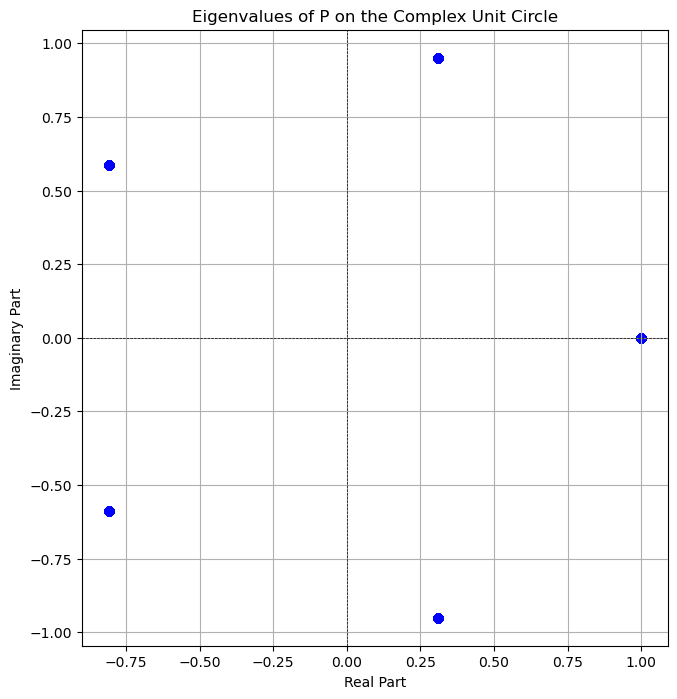

In [119]:
# Represent eigenvalues on the complex unit circle
plt.figure(figsize=(8, 8))
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), color='blue', alpha=0.7)
plt.title("Eigenvalues of P on the Complex Unit Circle")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal axis
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')  # Add vertical axis
plt.gca().set_aspect('equal', adjustable='box')  # Ensure the plot is circular
plt.grid(True)
plt.show()

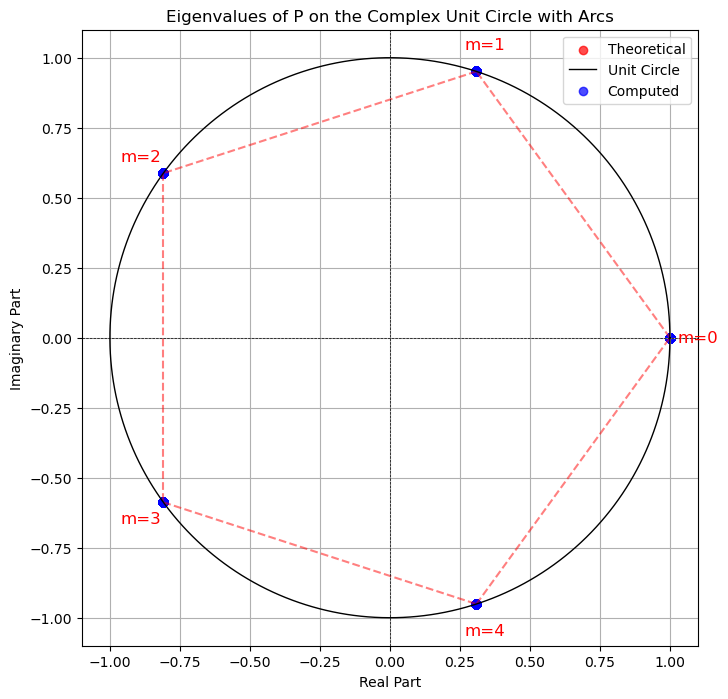

In [120]:
# Represent eigenvalues as e^(2i*pi*m/5) with m = 0, 1, 2, 3, 4
m_values = np.arange(5)  # m = 0, 1, 2, 3, 4
eigenvalues_theoretical = np.exp(2j * np.pi * m_values / 5)  # e^(2i*pi*m/5)

# Plot the theoretical eigenvalues on the complex unit circle
plt.figure(figsize=(8, 8))
plt.scatter(np.real(eigenvalues_theoretical), np.imag(eigenvalues_theoretical), color='red', label='Theoretical', alpha=0.7)

# Annotate the points with their corresponding m values
for m, ev in zip(m_values, eigenvalues_theoretical):
    plt.text(np.real(ev) * 1.1, np.imag(ev) * 1.1, f"m={m}", color='red', fontsize=12, ha='center', va='center')

# Connect the points with arcs
for i in range(len(eigenvalues_theoretical)):
    start = eigenvalues_theoretical[i]
    end = eigenvalues_theoretical[(i + 1) % len(eigenvalues_theoretical)]  # Wrap around to the first point
    arc_x = np.linspace(np.real(start), np.real(end), 100)
    arc_y = np.linspace(np.imag(start), np.imag(end), 100)
    plt.plot(arc_x, arc_y, color='red', linestyle='--', alpha=0.5)

# Draw the circumference of the unit circle in black
theta = np.linspace(0, 2 * np.pi, 500)
circle_x = np.cos(theta)
circle_y = np.sin(theta)
plt.plot(circle_x, circle_y, color='black', linewidth=1.0, label='Unit Circle')

# Plot the actual eigenvalues
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), color='blue', label='Computed', alpha=0.7)

# Add labels and grid
plt.title("Eigenvalues of P on the Complex Unit Circle with Arcs")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Horizontal axis
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')  # Vertical axis
plt.gca().set_aspect('equal', adjustable='box')  # Ensure the plot is circular
plt.legend()
plt.grid(True)
plt.show()

In [121]:
# Compute the absolute value squared of each eigenvalue
abs_squared_values = np.abs(eigenvalues)**2

# Print the absolute value squared for each eigenvalue
for i, value in enumerate(abs_squared_values):
    print(f"Eigenvalue {i}: |eigenvalue|^2 = {value:.5f}")

Eigenvalue 0: |eigenvalue|^2 = 1.00000
Eigenvalue 1: |eigenvalue|^2 = 1.00000
Eigenvalue 2: |eigenvalue|^2 = 1.00000
Eigenvalue 3: |eigenvalue|^2 = 1.00000
Eigenvalue 4: |eigenvalue|^2 = 1.00000
Eigenvalue 5: |eigenvalue|^2 = 1.00000
Eigenvalue 6: |eigenvalue|^2 = 1.00000
Eigenvalue 7: |eigenvalue|^2 = 1.00000
Eigenvalue 8: |eigenvalue|^2 = 1.00000
Eigenvalue 9: |eigenvalue|^2 = 1.00000
Eigenvalue 10: |eigenvalue|^2 = 1.00000
Eigenvalue 11: |eigenvalue|^2 = 1.00000
Eigenvalue 12: |eigenvalue|^2 = 1.00000
Eigenvalue 13: |eigenvalue|^2 = 1.00000
Eigenvalue 14: |eigenvalue|^2 = 1.00000
Eigenvalue 15: |eigenvalue|^2 = 1.00000
Eigenvalue 16: |eigenvalue|^2 = 1.00000
Eigenvalue 17: |eigenvalue|^2 = 1.00000
Eigenvalue 18: |eigenvalue|^2 = 1.00000
Eigenvalue 19: |eigenvalue|^2 = 1.00000
Eigenvalue 20: |eigenvalue|^2 = 1.00000
Eigenvalue 21: |eigenvalue|^2 = 1.00000
Eigenvalue 22: |eigenvalue|^2 = 1.00000
Eigenvalue 23: |eigenvalue|^2 = 1.00000
Eigenvalue 24: |eigenvalue|^2 = 1.00000
Eigenvalue

In [122]:
# Define the momentum sectors
momentum_sectors = {0: [], 1: [], 2: [], 3: [], 4: []}

# Assign eigenvalues to sectors based on their phase
for i, val in enumerate(eigenvalues):
    phase = np.angle(val)  # Compute the phase of the eigenvalue
    m = int(round(5 * phase / (2 * np.pi))) % 5  # Map phase to m (mod 5)
    momentum_sectors[m].append(val)

# Print the eigenvalues grouped by m
for m in sorted(momentum_sectors.keys()):
    print(f"Sector m={m}: {len(momentum_sectors[m])} eigenvalues")
    #print(momentum_sectors[m])

Sector m=0: 832 eigenvalues
Sector m=1: 816 eigenvalues
Sector m=2: 816 eigenvalues
Sector m=3: 816 eigenvalues
Sector m=4: 816 eigenvalues


In [123]:
H = transverse_field_ising_icosahedral(N, J, h)

# Compute all eigenvalues and corresponding eigenvectors
H_eigenvalues, H_eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(H_eigenvalues)}")

Eigenvalues of H: [-37.9456425  -33.85228906 -33.85228906 ...  36.38287836  40.95956435
  41.28675302]


In [124]:
# Round eigenvalues to a numerical precision to avoid floating-point issues
rounded_eigenvalues = np.round(H_eigenvalues, decimals=10)

# Count the degeneracy of each eigenvalue
unique_eigenvalues, degeneracies = np.unique(rounded_eigenvalues, return_counts=True)

# Print the results
print("Eigenvalue spectrum and degeneracies:")
for eigenvalue, degeneracy in zip(unique_eigenvalues, degeneracies):
    print(f"Eigenvalue: {eigenvalue}, Degeneracy: {degeneracy}")

Eigenvalue spectrum and degeneracies:
Eigenvalue: -37.9456424986, Degeneracy: 1
Eigenvalue: -33.8522890597, Degeneracy: 3
Eigenvalue: -32.3779521209, Degeneracy: 5
Eigenvalue: -29.6922721851, Degeneracy: 3
Eigenvalue: -29.3286428135, Degeneracy: 5
Eigenvalue: -28.5127169991, Degeneracy: 1
Eigenvalue: -28.4960539675, Degeneracy: 5
Eigenvalue: -28.3152268516, Degeneracy: 4
Eigenvalue: -27.953604519, Degeneracy: 1
Eigenvalue: -26.9017348693, Degeneracy: 4
Eigenvalue: -26.8977296548, Degeneracy: 5
Eigenvalue: -26.6953424325, Degeneracy: 3
Eigenvalue: -26.2190847339, Degeneracy: 5
Eigenvalue: -25.6544090637, Degeneracy: 4
Eigenvalue: -25.5495260893, Degeneracy: 3
Eigenvalue: -24.5036797902, Degeneracy: 4
Eigenvalue: -24.274529869, Degeneracy: 3
Eigenvalue: -24.1756117953, Degeneracy: 4
Eigenvalue: -24.1529896789, Degeneracy: 5
Eigenvalue: -24.1453677169, Degeneracy: 3
Eigenvalue: -23.9293590695, Degeneracy: 3
Eigenvalue: -23.8736679758, Degeneracy: 4
Eigenvalue: -23.534046222, Degeneracy: 5

In [125]:
# classify H_eigenvalues into C5 symmetry sectors

# Step 1: Identify degenerate subspaces
rounded_eigenvalues = np.round(H_eigenvalues, decimals=10)
unique_eigenvalues, degeneracies = np.unique(rounded_eigenvalues, return_counts=True)

# Dictionary to store indices of eigenstates for each degenerate eigenvalue
degenerate_subspaces = {}
for eigenvalue in unique_eigenvalues:
    indices = np.where(rounded_eigenvalues == eigenvalue)[0]
    degenerate_subspaces[eigenvalue] = indices

# Step 2: Project P onto each degenerate subspace and diagonalize
symmetry_sectors = {}  # To store m-values for each eigenstate
sector_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # Counter for each symmetry sector

for eigenvalue, indices in degenerate_subspaces.items():
    # Extract the degenerate subspace eigenvectors
    degenerate_subspace = H_eigenvectors[:, indices]
    
    # Project P onto the degenerate subspace
    P_subspace = degenerate_subspace.conj().T @ P @ degenerate_subspace
    
    # Diagonalize P in the degenerate subspace
    P_subspace_eigenvalues, P_subspace_eigenvectors = np.linalg.eig(P_subspace)
    
    # Step 3: Assign m-values based on the phase of eigenvalues
    m_values = []
    for eigenvalue in P_subspace_eigenvalues:
        phase = np.angle(eigenvalue)  # Compute the phase of the eigenvalue
        m = int(round(5 * phase / (2 * np.pi))) % 5  # Map phase to m (mod 5)
        m_values.append(m)
    
    # Store the m-values for the eigenstates in this subspace
    for i, index in enumerate(indices):
        symmetry_sectors[index] = m_values[i]
        sector_counts[m_values[i]] += 1  # Increment the counter for the corresponding sector


# Step 4: Print the symmetry sector for each eigenstate
for index, m in sorted(symmetry_sectors.items()):
    print(f"Eigenstate {index} belongs to symmetry sector m={m}")

# Step 5: Print the count of eigenstates in each symmetry sector
print("\nCount of eigenstates in each symmetry sector:")
for m, count in sector_counts.items():
    print(f"Symmetry sector m={m}: {count} eigenstates")

Eigenstate 0 belongs to symmetry sector m=0
Eigenstate 1 belongs to symmetry sector m=0
Eigenstate 2 belongs to symmetry sector m=2
Eigenstate 3 belongs to symmetry sector m=3
Eigenstate 4 belongs to symmetry sector m=0
Eigenstate 5 belongs to symmetry sector m=1
Eigenstate 6 belongs to symmetry sector m=4
Eigenstate 7 belongs to symmetry sector m=2
Eigenstate 8 belongs to symmetry sector m=3
Eigenstate 9 belongs to symmetry sector m=0
Eigenstate 10 belongs to symmetry sector m=1
Eigenstate 11 belongs to symmetry sector m=4
Eigenstate 12 belongs to symmetry sector m=2
Eigenstate 13 belongs to symmetry sector m=3
Eigenstate 14 belongs to symmetry sector m=1
Eigenstate 15 belongs to symmetry sector m=4
Eigenstate 16 belongs to symmetry sector m=0
Eigenstate 17 belongs to symmetry sector m=0
Eigenstate 18 belongs to symmetry sector m=2
Eigenstate 19 belongs to symmetry sector m=3
Eigenstate 20 belongs to symmetry sector m=1
Eigenstate 21 belongs to symmetry sector m=4
Eigenstate 22 belong

In [126]:
# classify eigevalues of P into C5 symmetry sectors

# Define the momentum sectors
momentum_sectors = {0: [], 1: [], 2: [], 3: [], 4: []}

# Assign eigenvalues to sectors based on their phase
for i, val in enumerate(eigenvalues):
    phase = np.angle(val)  # Compute the phase of the eigenvalue
    m = int(round(5 * phase / (2 * np.pi))) % 5  # Map phase to m (mod 5)
    momentum_sectors[m].append(val)

# Print the eigenvalues grouped by m
for m in sorted(momentum_sectors.keys()):
    print(f"Sector m={m}: {len(momentum_sectors[m])} eigenvalues")
    #print(momentum_sectors[m])

Sector m=0: 832 eigenvalues
Sector m=1: 816 eigenvalues
Sector m=2: 816 eigenvalues
Sector m=3: 816 eigenvalues
Sector m=4: 816 eigenvalues


In [127]:
# Compute the commutator [H, P]
commutator = H @ P - P @ H

# Check if the commutator is zero (within a numerical tolerance)
is_commuting = np.allclose(commutator.toarray(), np.zeros_like(commutator.toarray()), atol=1e-10)

# Print the result
print(f"Does H commute with P? {is_commuting}")

Does H commute with P? True


In [ ]:
# verify in which symmetry sectors of C5 the scarred states are

# Indices of the degenerate eigenstates
degenerate_indices = [1266, 1267, 1268, 1269, 1270]

# Extract the degenerate subspace eigenstates
degenerate_subspace = H_eigenvectors[:, degenerate_indices]

# Project P onto the degenerate subspace
P_subspace = degenerate_subspace.conj().T @ P @ degenerate_subspace

# Diagonalize P in the degenerate subspace
P_subspace_eigenvalues, P_subspace_eigenvectors = np.linalg.eig(P_subspace)

# Print the results
print("Eigenvalues of P in the degenerate subspace:")
print(P_subspace_eigenvalues)

print("\nEigenvectors of P in the degenerate subspace:")
print(P_subspace_eigenvectors)

Eigenvalues of P in the degenerate subspace:
[-0.80901699+0.58778525j -0.80901699-0.58778525j  0.30901699+0.95105652j
  0.30901699-0.95105652j  1.        +0.j        ]

Eigenvectors of P in the degenerate subspace:
[[-0.03635448+0.30851666j -0.03635448-0.30851666j  0.07864539+0.6267715j
   0.07864539-0.6267715j   0.09453267+0.j        ]
 [ 0.30851729-0.21177739j  0.30851729+0.21177739j -0.12924039+0.197194j
  -0.12924039-0.197194j   -0.78022928+0.j        ]
 [-0.1565906 -0.1438844j  -0.1565906 +0.1438844j   0.64869969+0.j
   0.64869969-0.j         -0.26063529+0.j        ]
 [ 0.09274727+0.58246466j  0.09274727-0.58246466j  0.07159947-0.26028741j
   0.07159947+0.26028741j -0.39813777+0.j        ]
 [ 0.60858259+0.j          0.60858259-0.j          0.22621683-0.0228578j
   0.22621683+0.0228578j   0.39479286+0.j        ]]


In [129]:
# Parametrize the eigenvalues of P in the degenerate subspace
m_values = []
for eigenvalue in P_subspace_eigenvalues:
    phase = np.angle(eigenvalue)  # Compute the phase of the eigenvalue
    m = int(round(5 * phase / (2 * np.pi))) % 5  # Map phase to m (mod 5)
    m_values.append(m)

# Check if the parametrization is possible
unique_m_values = set(m_values)
is_parametrization_possible = len(unique_m_values) == 5  # Check if all m values are unique

# Print the results
print("Eigenvalues of P in the degenerate subspace:")
print(P_subspace_eigenvalues)

print("\nCorresponding m values:")
print(m_values)

print("\nIs the parametrization possible?")
print(is_parametrization_possible)

Eigenvalues of P in the degenerate subspace:
[-0.80901699+0.58778525j -0.80901699-0.58778525j  0.30901699+0.95105652j
  0.30901699-0.95105652j  1.        +0.j        ]

Corresponding m values:
[2, 3, 1, 4, 0]

Is the parametrization possible?
True


In [134]:
# check in which symmetry sector the basis states are

basis = generate_spin_basis_with_binary(N)
print(basis)

[('000000000000', array([1, 0, 0, ..., 0, 0, 0])), ('000000000001', array([0, 0, 0, ..., 0, 0, 0])), ('000000000010', array([0, 0, 0, ..., 0, 0, 0])), ('000000000011', array([0, 0, 0, ..., 0, 0, 0])), ('000000000100', array([0, 0, 0, ..., 0, 0, 0])), ('000000000101', array([0, 0, 0, ..., 0, 0, 0])), ('000000000110', array([0, 0, 0, ..., 0, 0, 0])), ('000000000111', array([0, 0, 0, ..., 0, 0, 0])), ('000000001000', array([0, 0, 0, ..., 0, 0, 0])), ('000000001001', array([0, 0, 0, ..., 0, 0, 0])), ('000000001010', array([0, 0, 0, ..., 0, 0, 0])), ('000000001011', array([0, 0, 0, ..., 0, 0, 0])), ('000000001100', array([0, 0, 0, ..., 0, 0, 0])), ('000000001101', array([0, 0, 0, ..., 0, 0, 0])), ('000000001110', array([0, 0, 0, ..., 0, 0, 0])), ('000000001111', array([0, 0, 0, ..., 0, 0, 0])), ('000000010000', array([0, 0, 0, ..., 0, 0, 0])), ('000000010001', array([0, 0, 0, ..., 0, 0, 0])), ('000000010010', array([0, 0, 0, ..., 0, 0, 0])), ('000000010011', array([0, 0, 0, ..., 0, 0, 0])),